# Future cash flow notebook

This notebook performs basic personal income cash flow simulation. It uses probability distributions for interest rates, equity returns, and fixed income returns, and performs Monte Carlo methods to generate a histogram of possible cash flow outcomes. 

The simulation takes salary, inflation, interest, tax, equity returns, rebalancing, and basic retirement income flow changes into account. There are US tax and Australian tax bracket simulations. 

TODO:

* The probabilty distribution for the quantum harmonic oscillator to model returns (as per [this paper](https://ui.adsabs.harvard.edu/abs/2017EL....12038003A/abstract)) is slightly off. This notebook uses 1900+ S&P returns (including dividends) with a 'fitted distribution', but includes the QH model below (simply run that cell, instead of the S&P returns cell).  
*  best_fit_distribution should probably be replaced with [fitter](https://fitter.readthedocs.io/en/latest/)

LIMITATIONS: 

* No 401k/Superannuation tax modeling. 
* Capital gains on equities is treated as income, which is clearly wrong. No application of long-term capital gains tax discounts. 
* No simulation of primary residence/investment housing tax advantages, which are huge tax policy influences on capital outcomes. 
* Fitting a distribution to the S&P is fraught with danger: a) the distribution can bias one way or another simply by resampling the distribution, b) S&P likely doesn't give this distribution exposure to "dead companies" and is probably survivorship biased. One day I'll grab all EOD price data for ASX and NYSE/NASDAQ, including dead companies and try and build a proper equities return model.  

Python 3.9.5: works on my machine[tm].

In [1]:
import sys
import os
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import random
import warnings
import itertools

from matplotlib.ticker import FuncFormatter
from scipy.stats import norm, truncnorm, binom
from io import StringIO
from typing import cast, Union
from scipy.stats import truncnorm

### Helpers

In [2]:
# helper fuctions
def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

formatter = FuncFormatter(human_format)


def flatten(l):
    return [item for sublist in l for item in sublist]


def params_to_dict(params):
    return {
        'loc': params[-2],
        'scale': params[-1],
        'args': params[:-2],
    }

def fit_distribution(data, distribution_function, bins=200):
    # try and fit
    y, x = np.histogram(data, bins=bins, density=True)
    distribution = distribution_function
    params = distribution.fit(data)

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Calculate fitted PDF and error with fit in distribution
    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)

    return (x, pdf, params)


def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [
        st.alpha, st.anglit, st.arcsine, st.beta, st.betaprime, st.bradford, st.burr, st.cauchy, st.chi, st.chi2, st.cosine,
        st.dgamma, st.dweibull, st.erlang, st.expon, st.exponnorm, st.exponweib, st.exponpow, st.f, st.fatiguelife, st.fisk,
        st.foldcauchy, st.foldnorm, st.genlogistic, st.genpareto, st.gennorm, st.genexpon,
        st.genextreme, st.gausshyper, st.gamma, st.gengamma, st.genhalflogistic, st.gilbrat, st.gompertz, st.gumbel_r,
        st.gumbel_l, st.halfcauchy, st.halflogistic, st.halfnorm, st.halfgennorm, st.hypsecant, st.invgamma, st.invgauss,
        st.invweibull, st.johnsonsb, st.johnsonsu, st.ksone, st.kstwobign, st.laplace, st.levy, st.levy_l,
        st.logistic, st.loggamma, st.loglaplace, st.lognorm, st.lomax, st.maxwell, st.mielke, st.nakagami,
        st.norm, st.pareto, st.pearson3, st.powerlaw, st.powerlognorm, st.powernorm, st.rdist, st.reciprocal,
        st.rayleigh, st.rice, st.recipinvgauss, st.semicircular, st.t, st.triang, st.truncexpon, st.truncnorm, st.tukeylambda,
        st.uniform, st.vonmises, st.vonmises_line, st.wald, st.weibull_min, st.weibull_max, st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # logging.info('fitting {}'.format(distribution))
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)  # type: ignore
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution, best_params)


def get_truncated_normal(mean=0.0, sd=1.0, low=0.0, upp=10.0):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


def create_fanchart(arr, figsize=(15, 10)):
    x = np.arange(arr.shape[0])
    # for the median use `np.median` and change the legend below
    mean = np.mean(arr, axis=1)
    offsets = (10, 20, 30, 40, 45, 49, 50)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(mean, color='black', lw=2)
    for offset in offsets:
        low = np.percentile(arr, 50-offset, axis=1)
        high = np.percentile(arr, 50+offset, axis=1)
        # since `offset` will never be bigger than 50, do 55-offset so that
        # even for the whole range of the graph the fanchart is visible
        alpha = (55 - offset) / 100
        ax.fill_between(x, low, high, color='blue', alpha=alpha)
    ax.legend(['Mean'] + [f'Pct{2*o}' for o in offsets])
    return fig, ax

In [3]:
# we're not doing tax credit holdover here, just a basic application
def apply_tax_year(
    long_term_cap_flows: list[int], 
    short_term_cap_flows: list[int],
    income_flows: list[int], 
    apply_united_states_tax: bool = True
) -> int:
    au_tax_brackets: list[int] = [
        18201,
        45001,
        120001,
        180001,
        sys.maxsize,
    ]

    au_tax_rates: list[float] = [
        0.0,
        0.19,
        0.325,
        0.37,
        0.45
    ]

    tax_brackets: list[int] = [
        20550,
        83551,
        178151,
        340101,
        431901,
        647851,
        sys.maxsize,
    ]

    tax_rates: list[float] = [
        0.10,
        0.12,
        0.22,
        0.24,
        0.32,
        0.35,
        0.37,
    ]

    if not apply_united_states_tax:
        tax_brackets = au_tax_brackets
        tax_rates = au_tax_rates

    # do this properly for US taxes
    capital_gain_discount = 0.5
    taxes = []

    long_term_cap = sum(long_term_cap_flows) * capital_gain_discount 

    # apply
    accumulated_flow = long_term_cap + sum(short_term_cap_flows) + sum(income_flows)
    taxed_flow = 0.0

    for index, bracket in enumerate(tax_brackets):
        if accumulated_flow > bracket and index == len(tax_brackets) - 1:
            tax_applied = (accumulated_flow - taxed_flow) * tax_rates[index]
            taxes.append((tax_applied, bracket, taxed_flow, tax_rates[index]))
            taxed_flow = accumulated_flow
            break
        elif accumulated_flow >= bracket:
            tax_applied = (bracket - taxed_flow) * tax_rates[index]
            taxes.append((tax_applied, bracket, taxed_flow, tax_rates[index]))
            taxed_flow = bracket
        elif accumulated_flow < bracket and taxed_flow < accumulated_flow:
            tax_applied = (accumulated_flow - taxed_flow) * tax_rates[index]
            taxes.append((tax_applied, bracket, taxed_flow, tax_rates[index]))
            taxed_flow = accumulated_flow
        
    tax_paid = sum([x for (x, _, _, _) in taxes])
    return int(round(tax_paid))

## Set up the probability distributions for interest rates, equity returns and fixed income

We use: 

* Either: 1) fitted distribution to S&P returns data (including dividends) from 1920 onwards, or 2) Quantum harmonic oscillator for equity returns, modeled from this paper: https://iopscience.iop.org/article/10.1209/0295-5075/120/38003. (2) isn't quite calibrated properly, so use caution.
* Historical interest rates (US Treasury 10 year, 1920 onwards) from the Federal Reserve, fitting a distribution over the histogram.
* Historical inflation data, (US CPI data, 1913 onwards). This is harder to 'fit' a distribution to, so we just sample from that historical data.

(-0.05, 0.25)

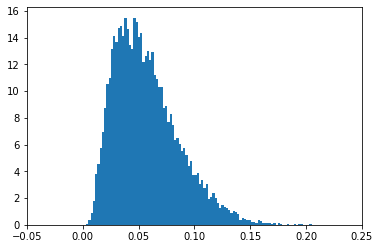

In [4]:
# get a distribution of interest rates stats
# this distribution is the current inflation rate for the given month. It doesn't need to be adjusted. 
interest_rates_data = requests.get('https://datahub.io/core/bond-yields-us-10y/r/monthly.csv').text
pd_interest_rates = pd.read_csv(StringIO(interest_rates_data), parse_dates=['Date'])

ir_data = pd_interest_rates['Rate'] / 100
distribution, params = best_fit_distribution(ir_data, 30)

args = params_to_dict(params)
interest_rate_distribution = distribution(*args['args'], scale=args['scale'], loc=args['loc'])
interest_rate_distribution_array = interest_rate_distribution.rvs(15000) 

fig, ax = plt.subplots()
_ = ax.hist(interest_rate_distribution_array, bins=100, density=True)
plt.xlim([-0.05, 0.25])
plt.show()

In [5]:
# this model/distribution isn't calibrated (it skews far too negative), but I left it here for folks who want to tinker.
import numpy.polynomial.hermite as herm
import math

def qho_fp(x_range, t, C, mw, h_bar=1, n=5):
    # This is taken from original paper, "Modeling stock return distributions with a quantum harmonic oscillator"
    # Appears that t is the length of increments
    pdf = []
    for i in range(len(x_range)):
        x = x_range[i]
        p = 0
        for i in range(n):
            # En = n*h_bar*w
            # p += (An / np.sqrt((s**n)*np.factorial(n))) * np.sqrt((m*w)/(pi*h_bar))*np.exp(-En*t) * \
            # hermval(np.sqrt(m*w/h_bar)*x) * np.exp(-m*w*x**2/h_bar)
            # Using the simplified fit formula from the paper
            p_prime = C[i] * herm.hermval((mw / h_bar)**0.5 * x, i) * np.exp(-mw*x**2/(h_bar))
            p += p_prime.real

        if math.isinf(p) or math.isnan(p):
            return pdf[0:i]
        else:
            pdf.append(p)

    return pdf

def fit_qho(X0, parameters, t, data, N):
    min_val = min(data)
    max_val = max(data)
    x_range = np.linspace(min_val, max_val, num=200)
    qho = qho_fp(x_range, t, parameters[0:5], parameters[5])
    pdf = [1000 * i for i in qho]
    if len(qho) < len(x_range):
        return None

    else:
        model = [X0]
        sampling_vector = []
        for i in range(len(pdf)):
            for j in range(int(pdf[i])):
                sampling_vector.append(x_range[i])

        for i in range(len(data)):
            model.append(np.random.choice(sampling_vector))

        return model

,0
count,30000.000000
mean,0.040217
std,0.121036
min,-0.344269
25%,-0.045080
50%,0.033836
75%,0.117427
max,0.572309


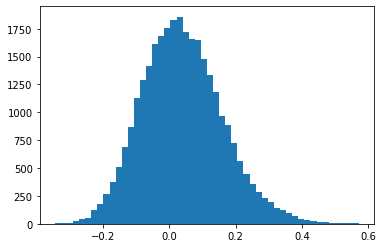

In [6]:
# currently deprecated in favor of the cell below. 
# model stock market returns. We're using Quantum Harmonic oscillator here. Code in quantum_harmonic.py 
parameters = [0.2, 0.2, 0.086, 0.182, 0.133, 0.928]

harmonic_data = requests.get('https://zd8d32753f2xm110ee.s3.us-west-2.amazonaws.com/quantumharmonic.csv').text
pd_harmonic_data = pd.read_csv(StringIO(harmonic_data))['close'].tolist()

daily_equity_qh_distribution_array = np.array(fit_qho(pd_harmonic_data[0], parameters, 1, pd_harmonic_data, 100)) / 100.0  # type: ignore

qh_equity_distribution_array = []
for i in range(30000):
    start = 100
    cumulative = 100
    # 250 trading days in a year
    for j in range(250):
        r = random.choice(daily_equity_qh_distribution_array)
        cumulative = cumulative + (cumulative * r)
    qh_equity_distribution_array.append((cumulative - start) / start)

_ = plt.hist(qh_equity_distribution_array, bins=50)

pd.DataFrame(qh_equity_distribution_array).describe()

,0
count,15000.000000
mean,0.111252
std,0.148138
min,-0.387727
25%,0.009629
50%,0.106153
75%,0.208054
max,0.755270


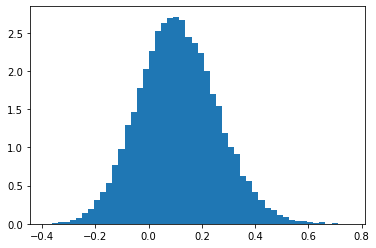

In [7]:
# S&P 500 returns from 1900-2022
# https://www.officialdata.org/us/stocks/s-p-500/1900

sandp_data = requests.get('https://zd8d32753f2xm110ee.s3.us-west-2.amazonaws.com/sandp1900-2022.csv').text
monthly_returns = np.array(pd.read_csv(StringIO(sandp_data), parse_dates=['date'])['return'].dropna())

distribution, params = best_fit_distribution(monthly_returns)
args = params_to_dict(params)

equity_distribution = distribution(*args['args'], scale=args['scale'], loc=args['loc'])
equity_distribution_rvs = equity_distribution.rvs(15000)

equity_distribution_array = []
for i in range(15000):
    start = 100
    cumulative = 100
    for j in range(12):
        r = random.choice(equity_distribution_rvs)
        cumulative = cumulative + (cumulative * r)
    equity_distribution_array.append((cumulative - start) / start)

_ = plt.hist(equity_distribution_array, bins=50, density=True)

pd.DataFrame(equity_distribution_array).describe()

(-0.25, 0.25)

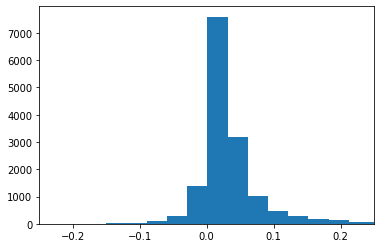

In [8]:
# inflation data grabbed from the fed originally, and just dropped in as a list
inflation_data = np.array([0.02,0.09,0.18,0.13,0.1,0.16,-0.12,-0.08,0,-0.02,0.01,0.01,-0.01,0.01,0.01,-0.01,-0.1,-0.09,-0.04,0.01,0,0.02,0.04,0.01,-0.01,0.04,0.06,0.05,0.02,0.01,0.01,0.03,0.09,0.14,0.03,0.03,0.11,0.03,-0.01,0.01,0,0.01,0.03,0.02,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.04,0.04,0.04,0.05,0.03,0.03,0.05,0.07,0.11,0.11,0.08,0.08,0.09,0.09,0.1,0.12,0.11,0.06,0.04,0.04,0.04,0.04,0.04,0.05,0.05,0.06,0.01,0.02,0,0.02,0.02,0.02,0.01,0.02,0.03,0.03,0.02,0.03,0.02,0.02,0.02,0.02,0.02,0,0.02,0.03,0.02,0.01,0.02,0.01,0.01,0.02,0.02,0.02,0.01,0.03,0.07])
distribution, params = best_fit_distribution(inflation_data, bins=25)

args = params_to_dict(params)
inflation_rate_distribution = distribution(*args['args'], scale=args['scale'], loc=args['loc'])
inflation_rate_array = inflation_rate_distribution.rvs(15000)

fig, ax = plt.subplots()
_ = ax.hist(inflation_rate_array, bins=200)
plt.xlim([-0.25, 0.25])
plt.show()

## Code to simulate cash flow returns over time

Call "sample", with options: 

* Current age, years remaining. 
* Starting fixed income (cash, CD's/term deposits)
* Starting equity (sum up your current equity holdings)
* Adjust for inflation (bool)
* Adjust for taxes (bool)
* Adjust for a basic stock/fixed rebalancing according to age.
* Apply US tax brackets (bool, False to apply Australian tax brackets)

In [9]:

# generate a dictionary where the keys are a persons age, and the value is the bond to equity ratio appropriate for that age
equity_fixed_ratio_by_age = {
    value: 1 - (1 / (1 + np.exp(-0.1 * (value - 50)))) for (key, value) in enumerate(range(20, 90))
}


def sample_year_return(fixed: float, equity: float) -> tuple[tuple[float, float], tuple[int, int]]:
    fixed_return: float = random.choice(interest_rate_distribution_array)
    equity_return: float = random.choice(equity_distribution_array)

    fixed_post: float = fixed * fixed_return if fixed > 0 else 0
    equity_post: float = equity * equity_return if equity > 0 else 0

    return ((fixed_return, equity_return), (int(fixed_post), int(equity_post)))    


def sample_inflation() -> float:
    return random.choice(inflation_data)


def rebalance_portfolio(fixed_to_equity_ratio: float, fixed: float, equity: float) -> tuple[int, int]:
    total = fixed + equity
    fixed = total * (1 - fixed_to_equity_ratio)
    equity = total * (fixed_to_equity_ratio)
    return (int(fixed), int(equity))


def sample(
    samples: int, 
    age: int,
    retirement_age: int,
    years_remaining: int,
    starting_salary: int,
    starting_expenses: int,
    retirement_expenses: int,
    starting_fixed_income: int, 
    starting_equity: int,
    tax: bool = False,
    apply_us_tax_rates = True,
    rebalance: bool = False,
    inflation_adjust: bool = False,
) -> list[dict[str, list[Union[int, float]]]]: 

    return_samples: list[dict[str, list[Union[int, float]]]] = []

    for sample in range(0, samples):
        yearly_fixed_percentage = []
        yearly_equity_percentage = []
        yearly_capital: list[tuple[int, int]] = [(starting_fixed_income, starting_equity)]

        salary = starting_salary
        expenses = starting_expenses
        year_count = 0

        for year in range(age, age + years_remaining):
            cap_fixed = yearly_capital[-1][0]
            cap_equity = yearly_capital[-1][1]
            
            # retirement
            if year == retirement_age:
                expenses = retirement_expenses
                salary = 0

            # get returns from fixed income and stock flows
            (fixed_perc_return, equity_perc_return), capital_returns = sample_year_return(cap_fixed, cap_equity)

            # add salary to taxable fixed income
            capital_returns = (capital_returns[0] + salary, capital_returns[1])

            # todo: not doing anything here with long term cap gains vs. short. All treated as income right now
            total_tax = 0
            if tax:
                total_tax = apply_tax_year(
                    [0], 
                    [capital_returns[0]], 
                    [capital_returns[1]],
                    apply_united_states_tax=apply_us_tax_rates)

            # add the return for the year on to the pile of money, subtract expenses and taxes
            new_balances = (capital_returns[0] + cap_fixed - expenses - total_tax, capital_returns[1] + cap_equity)

            # if we're short on fixed income, sell some equity to make up the difference
            if new_balances[0] < 0 and new_balances[1] > 0 and (new_balances[1] + new_balances[0] > 0):
                new_balances = (0, new_balances[1] + new_balances[0])
                
            if rebalance:
                new_balances = rebalance_portfolio(equity_fixed_ratio_by_age[year], new_balances[0], new_balances[1])

            if inflation_adjust:
                inflation = sample_inflation()
                # if balance is negative, we can assume we're in debt, and inflation inflates that debt away
                # -100 - (-100 * 0.05) = -100 - -5 = -95
                new_balances = (
                    int(new_balances[0] - (new_balances[0] * inflation)), 
                    int(new_balances[1] - (new_balances[1] * inflation))
                )
                salary = int(salary + (salary * inflation))
                expenses = int(expenses + (expenses * inflation))

            yearly_fixed_percentage.append(fixed_perc_return)
            yearly_equity_percentage.append(equity_perc_return)
            yearly_capital.append(new_balances)


        return_samples.append({
            'fixed_perc_return': yearly_fixed_percentage,
            'equity_perc_return': yearly_equity_percentage,
            'fixed': [x[0] for x in yearly_capital],
            'equity': [x[1] for x in yearly_capital],
        })
            
    return return_samples

In [10]:
# Inputs
age = 40
retirement_age = 65
death = 85 
start_salary = 150000 
start_expenses = 70000 
retirement_expenses = 50000 

start_fixed_income = 100000 
start_equity = 100000 

apply_us_tax_rates = True 
years_remaining = death - age

result = sample(
    samples=10000, 
    age=age,
    retirement_age=retirement_age,
    years_remaining=years_remaining,
    starting_salary=start_salary,
    starting_expenses=start_expenses,
    retirement_expenses=retirement_expenses,
    starting_fixed_income=start_fixed_income, 
    starting_equity=start_equity,
    inflation_adjust=True,
    tax=True,
    apply_us_tax_rates=apply_us_tax_rates,
    rebalance=True,
)

# last year of each sample
fixed_capital_flat: list[float] = [x['fixed'][-1] for x in result]
equity_capital_flat: list[float] = [x['equity'][-1] for x in result]
total_capital_flat = list(map(sum, zip(fixed_capital_flat, equity_capital_flat)))

fixed_perc_return: list[float] = flatten([x['fixed_perc_return'] for x in result])
equity_perc_return: list[float] = flatten([x['equity_perc_return'] for x in result])

fixed_samples = [x['fixed'] for x in result]
equity_samples = [x['equity'] for x in result]
transposed_fixed = list(map(list, itertools.zip_longest(*fixed_samples, fillvalue=None)))
transposed_equity = list(map(list, itertools.zip_longest(*equity_samples, fillvalue=None)))
total_capital_over_time = np.array(transposed_fixed) + np.array(transposed_equity)

0.13999999999999999% of samples for "last year capital" went negative


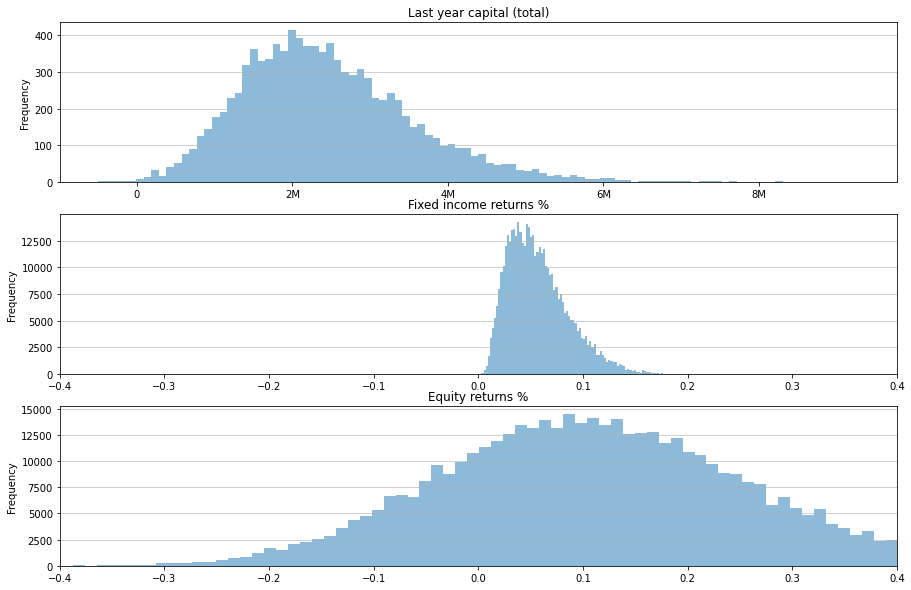

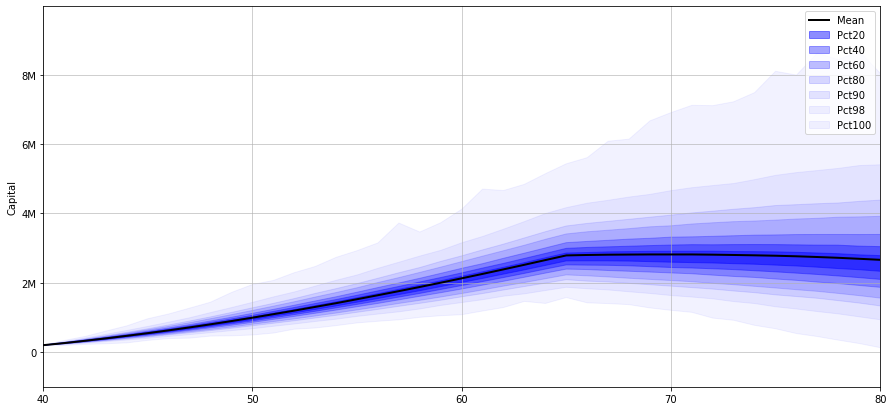

In [11]:
# plot everything
fig, ax = plt.subplots(3, figsize=(15, 10))
ax[0].grid(axis='y', alpha=0.75)
_ = ax[0].set_ylabel('Frequency')
_ = ax[0].set_title('Last year capital (total)')
ax[0].xaxis.set_major_formatter(formatter)

ax[1].grid(axis='y', alpha=0.75)
_ = ax[1].set_ylabel('Frequency')
_ = ax[1].set_title('Fixed income returns %')
_ = ax[1].set_xlim([-.4, .4])  # type: ignore

ax[2].grid(axis='y', alpha=0.75)
_ = ax[2].set_ylabel('Frequency')
_ = ax[2].set_title('Equity returns %')
_ = ax[2].set_xlim([-.4, .4])  # type: ignore

_ = ax[0].hist(total_capital_flat, bins=100, alpha=0.5)
_ = ax[1].hist(fixed_perc_return, bins=100, alpha=0.5)
_ = ax[2].hist(equity_perc_return, bins=100, alpha=0.5)

fig, ax = create_fanchart(total_capital_over_time, figsize=(15, 7))
_ = ax.set_xticks(ax.get_xticks(), (np.array(ax.get_xticks()) + age).astype(int))
_ = ax.set_xlim(left=0, right=age)
_ = ax.grid(axis='y', alpha=0.75)
_ = ax.grid(axis='x', alpha=0.75)
_ = ax.set_ylabel('Capital')
_ = ax.yaxis.set_major_formatter(formatter)

samples_below_zero = len([x for x in total_capital_over_time[-1] if x <= 0])
percentage_samples_below_zero = samples_below_zero / len(total_capital_over_time[-1])
print(f'{percentage_samples_below_zero * 100}% of samples for "last year capital" went negative')
